In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from datetime import datetime
from functools import reduce
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

c:\Users\joebe\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_directory = '../data/'
file_names = [
    'Batch_corrected_Expression_Public_24Q4_subsetted.csv',
    'Damaging_Mutations_subsetted.csv', 
    'Harmonized_RPPA_CCLE_subsetted.csv',
    'Hotspot_Mutations_subsetted.csv', 
    'IC50_AUC_merged.csv', 
    'Metabolomics_subsetted.csv',
    'miRNA_Expression_subsetted.csv',
    'Omics_Absolute_CN_Gene_Public_24Q4_subsetted.csv'
    ]
model_type = "Linear_Regression"

# Data Load

In [3]:
smiles = pd.read_csv("../data/drugID_name_pubchem_smiles.csv")

In [4]:
# load ChemBERTa tokenizer and model
model_name = "seyonec/ChemBERTa-zinc-base-v1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# tokenize
tokens = tokenizer(smiles["smiles"].tolist(), padding=True, truncation=True, return_tensors="pt")

# embedded tokenized SMILES
with torch.no_grad():
    outputs = model(**tokens)

# CLS token (for now, we will only use CLS token)
cls_embeddings = outputs.last_hidden_state[:, 0, :] # (batch_size, hidden_dim)

cls_embeddings_np = cls_embeddings.cpu().numpy()

smiles["CLS"] = list(cls_embeddings_np)

print(smiles.head())

   drugID          drugName  pubchemID  \
0    1003  (+)-CAMPTOTHECIN      24360   
1    1004            VELBAN    5388983   
2    1006        CYTARABINE       6253   
3    1007         DOCETAXEL     148124   
4    1010         GEFITINIB     123631   

                                              smiles  \
0  CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...   
1  CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...   
2                 C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O   
3  CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...   
4  COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...   

                                                 CLS  
0  [-0.050628018, 0.88478583, -1.6744763, 1.31876...  
1  [1.524386, 0.27689624, -0.80197245, -0.9936369...  
2  [-0.39218664, 0.06059071, -0.88434273, 0.23520...  
3  [0.5116886, 0.7362517, -1.3978803, -0.69533825...  
4  [-0.73378813, 0.74604344, -1.19528, 1.1188792,...  


In [5]:
IC50_AUC = pd.read_csv("../data/IC50_AUC_merged.csv")
IC50_AUC = IC50_AUC.rename(columns={"Unnamed: 0": "CellLineID"})

In [6]:
melted = IC50_AUC.melt(
    id_vars=["CellLineID"],  # fixed column
    var_name="metric_drug",  # column names that will be one single column
    value_name="value"       
)
melted.head()

,CellLineID,metric_drug,value
0,ACH-000001,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN
1,ACH-000002,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.358658
2,ACH-000004,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-6.277264
3,ACH-000006,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,-5.994797
4,ACH-000007,Drug sensitivity IC50 (Sanger GDSC2) (+)-CAMPT...,NaN


In [7]:
# ex: "Drug sensitivity AUC (Sanger GDSC2) CAMPTOTHECIN (GDSC2:1003)" -> (AUC), (CAMPTOTHECIN), (1003)
pattern = r"(AUC|IC50).*?\((Sanger GDSC2)\)\s+(.*?)\s+\(GDSC2:(\d+)\)"

# (AUC|IC50) -> 1) AUC or IC50
# (.*?)      -> 3) Drug name (minimum match)
# (\d+)      -> 4) drug number from GDSC2:XXXX

In [8]:
melted[["Metric", "_sanger", "DrugName", "DrugNumber"]] = melted["metric_drug"].str.extract(pattern)
new_melted = melted[['CellLineID', 'value', 'Metric','DrugNumber']]
new_melted.head()

,CellLineID,value,Metric,DrugNumber
0,ACH-000001,NaN,IC50,1003
1,ACH-000002,-6.358658,IC50,1003
2,ACH-000004,-6.277264,IC50,1003
3,ACH-000006,-5.994797,IC50,1003
4,ACH-000007,NaN,IC50,1003


In [9]:
final_IC50_AUC = (
    new_melted
    .pivot(index=["CellLineID", "DrugNumber"], 
           columns="Metric", 
           values="value")
    #.reset_index()
)

In [10]:
final_IC50_AUC = final_IC50_AUC.dropna(subset=['AUC', 'IC50'], how='all') # drop the row that AUC and IC50 are both NAN
final_IC50_AUC.columns.name = None
final_IC50_AUC

AUC     IC50
CellLineID DrugNumber                   
ACH-000001 1003        0.967187      NaN
           1004        0.666062      NaN
           1005        0.977907      NaN
           1007        0.922989      NaN
           1010        0.957586      NaN
...                         ...      ...
ACH-002317 2096        0.946713      NaN
           2107        0.926422      NaN
           2109        0.916274  3.25832
           2110        0.906540      NaN
           2170        0.996681      NaN

[98430 rows x 2 columns]

In [11]:
final_IC50_AUC.to_csv("temp.csv") # had to save and reload to make CellLIneID and DrugNumber to column

In [12]:
IC50_AUC_final = pd.read_csv("temp.csv")

In [13]:
# merge IC50, AUC, and SMILES (CLS)
df_merged = pd.merge(IC50_AUC_final, smiles, left_on='DrugNumber', right_on='drugID', how='inner')

In [14]:
IC50_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'IC50']].copy()
IC50_data['AUC'] = None # each row will have either AUC or IC50 value. 
ic50_data = IC50_data.rename(columns={'IC50': 'IC50'})

auc_data = df_merged[['CellLineID', 'DrugNumber', 'smiles', 'CLS', 'AUC']].copy()
auc_data['IC50'] = None 
auc_data = auc_data.rename(columns={'AUC': 'AUC'})

final_df = pd.concat([ic50_data, auc_data])
final_df = final_df.sort_values(by=['CellLineID', 'DrugNumber']).reset_index(drop=True)
final_df = final_df.dropna(subset=['AUC', 'IC50'], how='all').reset_index(drop=True)

final_df

C:\Users\joebe\AppData\Local\Temp\ipykernel_15468\1293473835.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([ic50_data, auc_data])


,CellLineID,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000001,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",NaN,0.967187
1,ACH-000001,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",NaN,0.666062
2,ACH-000001,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",NaN,0.977907
3,ACH-000001,1007,CC1=C2C(C(=O)C3(C(CC4C(C3C(C(C2(C)C)(CC1OC(=O)...,"[0.5116886, 0.7362517, -1.3978803, -0.69533825...",NaN,0.922989
4,ACH-000001,1010,COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)OC...,"[-0.73378813, 0.74604344, -1.19528, 1.1188792,...",NaN,0.957586
...,...,...,...,...,...,...
117641,ACH-002317,2107,C1COCCN1C2=CC=C(C=C2)C3=C(C=NC=C3)C4=CC(=C(C(=...,"[0.32438743, -0.20456038, -0.47426504, 0.15297...",NaN,0.926422
117642,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",3.25832,NaN
117643,ACH-002317,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",NaN,0.916274
117644,ACH-002317,2110,C1CC(C1)NC2=NC=CC(=C2)C(=O)NCC(CN3CCC4=CC=CC=C...,"[-0.07692237, -0.47833273, -0.6763192, -0.5061...",NaN,0.906540


In [15]:
all_omics = []
files = file_names[:4] + file_names[5:]
for file in files: 
    omics = pd.read_csv(f'{data_directory}{file}')
    omics = omics.rename(columns={omics.columns[0]: "CellLineID"})
    all_omics.append(omics)
all_omics

[      CellLineID     NEMP2   SPDYE11      MED6    SPATA1    HMG20B    PITRM1  \
 0     ACH-000873  2.281262  0.016496  4.913394  0.592549  4.933815  5.068384   
 1     ACH-000860  2.397921 -0.007359  6.064227  0.790612  5.526024  5.495815   
 2     ACH-000439  1.961548  0.139871  4.366399  0.574739  5.879936  5.027458   
 3     ACH-000318  2.962951 -0.007359  6.028266  0.636129  4.722188  5.235858   
 4     ACH-001142  1.997125 -0.007359  4.781246  1.004993  5.559541  6.614231   
 ...          ...       ...       ...       ...       ...       ...       ...   
 1668  ACH-001843  2.425672  0.016474  5.064429  1.155729  6.132326  6.435993   
 1669  ACH-002074  2.435179  0.016474  4.795754  0.494388  5.265443  5.683454   
 1670  ACH-001164  1.893673  0.016474  4.460321  0.362453  5.729537  7.230451   
 1671  ACH-003180  2.717188  0.016474  4.991506  0.604765  5.400438  5.396326   
 1672  ACH-001979  2.882293  0.040215  4.678718  0.717236  6.455945  4.943213   
 
         TCIRG1    CDKN2B 

In [16]:
X_dimension_reduced_array = []
# PCA for batch expression and CN, variance for damaged

for i in range(len(all_omics)):
    omics = all_omics[i]
    if i == 0 or i == 6:
        X_cnv = omics.iloc[:, 1:]
        pca = PCA(n_components=500)
        X_pca = pca.fit_transform(X_cnv)

        X_pca_df = pd.DataFrame(X_pca)
        X_pca_df.insert(0, "CellLineID", omics["CellLineID"].values)

        print(X_pca_df.shape)
        X_dimension_reduced_array.append(X_pca_df)

    elif i == 1:
        omics_ = omics.drop(columns="CellLineID")
        # VarianceThreshold 설정 (0에 가까운 값이 대부분인 feature 제거)
        selector = VarianceThreshold(threshold=0.01) # 분산 0.01 이하의 feature 제거
        omics_reduced = selector.fit_transform(omics_)

        # 제거되지 않은 feature의 인덱스 가져오기
        selected_columns = omics_.columns[selector.get_support()]

        # DataFrame으로 변환 (컬럼 유지)
        X_reduced_df = pd.DataFrame(omics_reduced, columns=selected_columns)
        X_reduced_df = pd.concat([omics["CellLineID"], X_reduced_df], axis=1)

        print(X_reduced_df.shape)
        X_dimension_reduced_array.append(X_reduced_df)

    else:
        print(omics.shape)
        X_dimension_reduced_array.append(omics)





(1673, 501)
(1929, 1255)
(899, 145)
(1929, 540)
(927, 226)
(954, 735)
(1607, 501)


In [17]:
df_merged = reduce(lambda left, right: pd.merge(left, right, on='CellLineID', how='inner', suffixes=('', '_dup')), X_dimension_reduced_array + [final_df])
df_merged

,CellLineID,0,1,2,3,4,5,6,7,8,...,495_dup,496_dup,497_dup,498_dup,499_dup,DrugNumber,smiles,CLS,IC50,AUC
0,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,1.576662,-3.378440,-0.924037,4.866052,-0.375463,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",-4.325557,NaN
1,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,1.576662,-3.378440,-0.924037,4.866052,-0.375463,1003,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,"[-0.050628018, 0.88478583, -1.6744763, 1.31876...",NaN,0.866413
2,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,1.576662,-3.378440,-0.924037,4.866052,-0.375463,1004,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,"[1.524386, 0.27689624, -0.80197245, -0.9936369...",NaN,0.906722
3,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,1.576662,-3.378440,-0.924037,4.866052,-0.375463,1005,N.N.[Cl-].[Cl-].[Pt+2],"[0.734997, 0.018372245, -0.4958414, 0.2950676,...",NaN,0.955195
4,ACH-000873,-8.385960,30.391703,-0.819295,44.671643,-26.321860,5.701811,-31.807342,9.832625,0.288482,...,1.576662,-3.378440,-0.924037,4.866052,-0.375463,1006,C1=CN(C(=O)N=C1N)C2C(C(C(O2)CO)O)O,"[-0.39218664, 0.06059071, -0.88434273, 0.23520...",NaN,0.932728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59298,ACH-001151,-35.889203,44.332540,8.323255,-28.598083,13.124804,-8.325410,16.091490,0.946869,20.182441,...,1.159935,2.255093,-1.867334,0.268329,-2.075966,2096,CC1=CN=C(N=C1C2=CNC(=C2)C(=O)NC(CO)C3=CC(=CC=C...,"[-0.058415245, 0.46983275, -0.7466096, -0.0175...",NaN,0.822895
59299,ACH-001151,-35.889203,44.332540,8.323255,-28.598083,13.124804,-8.325410,16.091490,0.946869,20.182441,...,1.159935,2.255093,-1.867334,0.268329,-2.075966,2106,CN1C(=C(C=N1)Cl)C2=C(OC(=C2)C(=O)NC(CC3=CC(=C(...,"[0.20707858, 0.6954128, -1.7764987, 0.8822796,...",NaN,0.929802
59300,ACH-001151,-35.889203,44.332540,8.323255,-28.598083,13.124804,-8.325410,16.091490,0.946869,20.182441,...,1.159935,2.255093,-1.867334,0.268329,-2.075966,2109,CC1CN(CC(N1)C)C2=NC=C(C(=C2)C)C3=CC=C(C=C3)C4=...,"[0.16195172, -0.26682645, -1.0635837, -0.43481...",NaN,0.944861
59301,ACH-001151,-35.889203,44.332540,8.323255,-28.598083,13.124804,-8.325410,16.091490,0.946869,20.182441,...,1.159935,2.255093,-1.867334,0.268329,-2.075966,2111,CS(=O)(=O)C1=CC=C(C=C1)C2=CN=C(C(=N2)C(=O)NC3=...,"[0.059471093, -0.31746727, -1.1127882, -0.1648...",NaN,0.980634


In [18]:
# split to feature and target
X = df_merged.drop(columns=["CellLineID", "DrugNumber",	"smiles", "AUC", "IC50"])
y = df_merged[["AUC", "IC50"]]
X.head()

,0,1,2,3,4,5,6,7,8,9,...,491_dup,492_dup,493_dup,494_dup,495_dup,496_dup,497_dup,498_dup,499_dup,CLS
0,-8.38596,30.391703,-0.819295,44.671643,-26.32186,5.701811,-31.807342,9.832625,0.288482,13.183089,...,0.933064,4.484646,-4.278636,-10.420709,1.576662,-3.37844,-0.924037,4.866052,-0.375463,"[-0.050628018, 0.88478583, -1.6744763, 1.31876..."
1,-8.38596,30.391703,-0.819295,44.671643,-26.32186,5.701811,-31.807342,9.832625,0.288482,13.183089,...,0.933064,4.484646,-4.278636,-10.420709,1.576662,-3.37844,-0.924037,4.866052,-0.375463,"[-0.050628018, 0.88478583, -1.6744763, 1.31876..."
2,-8.38596,30.391703,-0.819295,44.671643,-26.32186,5.701811,-31.807342,9.832625,0.288482,13.183089,...,0.933064,4.484646,-4.278636,-10.420709,1.576662,-3.37844,-0.924037,4.866052,-0.375463,"[1.524386, 0.27689624, -0.80197245, -0.9936369..."
3,-8.38596,30.391703,-0.819295,44.671643,-26.32186,5.701811,-31.807342,9.832625,0.288482,13.183089,...,0.933064,4.484646,-4.278636,-10.420709,1.576662,-3.37844,-0.924037,4.866052,-0.375463,"[0.734997, 0.018372245, -0.4958414, 0.2950676,..."
4,-8.38596,30.391703,-0.819295,44.671643,-26.32186,5.701811,-31.807342,9.832625,0.288482,13.183089,...,0.933064,4.484646,-4.278636,-10.420709,1.576662,-3.37844,-0.924037,4.866052,-0.375463,"[-0.39218664, 0.06059071, -0.88434273, 0.23520..."


In [19]:
y.head()

,AUC,IC50
0,NaN,-4.325557
1,0.866413,NaN
2,0.906722,NaN
3,0.955195,NaN
4,0.932728,NaN


In [20]:
cls_array = X["CLS"]
omics_array = X.drop(columns="CLS").to_numpy(dtype=np.float32)
y_array = y.to_numpy(dtype=np.float32)

# Scaling
# Omics -> Z-score normalization
scaler_omics = StandardScaler()
omics_array = scaler_omics.fit_transform(omics_array)

# AUC -> log transformation
epsilon = 1e-10  # prevent zero division
y_array[:, 0] = np.log10(np.where(y_array[:, 0] == 0, epsilon, y_array[:, 0]))
# Maybe MinMax Scaling?
#scaler_AUC = MinMaxScaler()
#y_array[:, 0] = scaler_AUC.fit_transform(y_array[:, 0].reshape(-1, 1)).flatten()

# IC50 -> MinMax Scaling
scaler_IC50 = MinMaxScaler()
y_array[:, 1] = scaler_IC50.fit_transform(y_array[:, 1].reshape(-1, 1)).flatten()

In [21]:
# train, validation, test : 80, 10, 10
train_smiles, test_smiles, train_omics, test_omics, train_y, test_y = train_test_split(
    cls_array, omics_array, y_array, test_size=0.1, random_state=42
)

print("train_smiles shape =", train_smiles.shape)
print("test_smiles shape =", test_smiles.shape)
print("train_omics shape =", train_omics.shape)
print("test_omics shape =", test_omics.shape)
print("train_y shape =", train_y.shape)
print("test_y shape =", test_y.shape)

train_smiles shape = (53372,)
test_smiles shape = (5931,)
train_omics shape = (53372, 3896)
test_omics shape = (5931, 3896)
train_y shape = (53372, 2)
test_y shape = (5931, 2)


# Model

First, we need to split the y data so we can fit two separate KNN models for IC50 and AUC

In [22]:
train_y_AUC = train_y[:, 0]
train_y_IC50 = train_y[:, 1]
test_y_AUC = test_y[:, 0]
test_y_IC50 = test_y[:, 1]

In [23]:
ic50_mask = ~np.isnan(train_y_IC50)
auc_mask = ~np.isnan(train_y_AUC)

train_y_IC50 = train_y_IC50[ic50_mask]
train_y_AUC = train_y_AUC[auc_mask]

train_smiles_array = np.vstack(train_smiles.values).astype('float32') 
train_x = np.hstack((train_smiles_array, train_omics))
train_x_IC50 = train_x[ic50_mask]
train_x_AUC = train_x[auc_mask]

In [29]:
# Hyperparams
estimators = 200
max_depth = 10
bootstrap=True

In [30]:
model_AUC = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth, bootstrap=bootstrap, verbose=2)
model_IC50 = RandomForestRegressor(n_estimators=estimators, max_depth=max_depth, bootstrap=bootstrap, verbose=2)

In [31]:
# DO NOT FACTOR NAN - IGNORE THEM IN EMBEDDING

model_AUC.fit(train_x_AUC, train_y_AUC)
model_IC50.fit(train_x_IC50, train_y_IC50)

building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200


[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed: 24.1min


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed: 95.0min


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200
building tree 1 of 200
bu

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  5.8min


building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54 of 200
building tree 55 of 200
building tree 56 of 200
building tree 57 of 200
building tree 58 of 200
building tree 59 of 200
building tree 60 of 200
building tree 61 of 200
building tree 62 of 200
building tree 63 of 200
building tree 64 of 200
building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82

[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed: 23.4min


building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200
building tree 195 of 200
building tree 196 of 200
building tree 197 of 200
building tree 198 of 200
building tree 199 of 200
building tree 200 of 200


RandomForestRegressor(max_depth=10, n_estimators=200, verbose=2)

In [32]:
test_ic50_mask = ~np.isnan(test_y_IC50)
test_auc_mask = ~np.isnan(test_y_AUC)

test_y_IC50 = test_y_IC50[test_ic50_mask]
test_y_AUC = test_y_AUC[test_auc_mask]

test_smiles_array = np.vstack(test_smiles.values).astype('float32') 
test_x = np.hstack((test_smiles_array, test_omics))
test_x_IC50 = test_x[test_ic50_mask]
test_x_AUC = test_x[test_auc_mask]

In [33]:
y_pred_AUC = model_AUC.predict(test_x_AUC)
y_pred_IC50 = model_IC50.predict(test_x_IC50)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s


In [34]:
y_pred_IC50.shape

(1079,)


 **Test Results:**
IC50_MSE: 0.0049
IC50_MAE: 0.0513
IC50_R2: 0.8629
AUC_MSE: 0.0032
AUC_MAE: 0.0320
AUC_R2: 0.6484


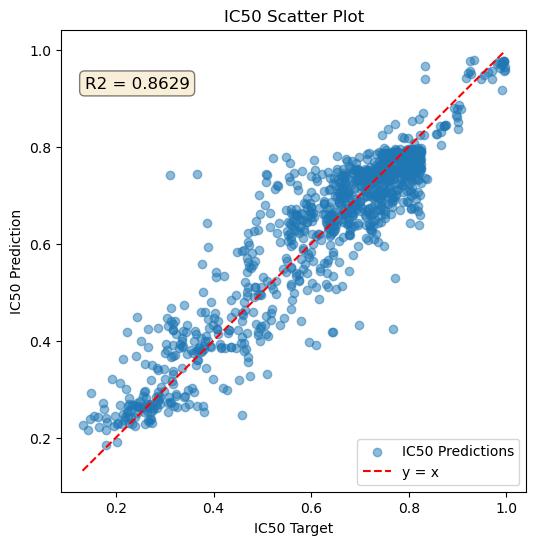

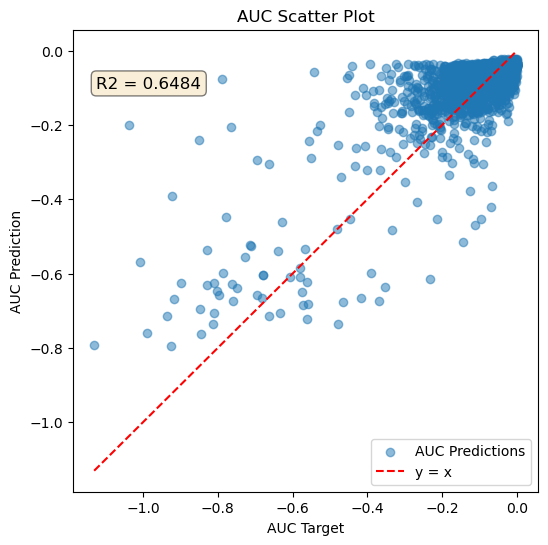

In [35]:
# evaluation
metrics = {}
if len(y_pred_IC50) > 0:
    metrics["IC50_MSE"] = mean_squared_error(test_y_IC50, y_pred_IC50)
    metrics["IC50_MAE"] = mean_absolute_error(test_y_IC50, y_pred_IC50)
    metrics["IC50_R2"] = r2_score(test_y_IC50, y_pred_IC50)
if len(y_pred_AUC) > 0:
    metrics["AUC_MSE"] = mean_squared_error(test_y_AUC, y_pred_AUC)
    metrics["AUC_MAE"] = mean_absolute_error(test_y_AUC, y_pred_AUC)
    metrics["AUC_R2"] = r2_score(test_y_AUC, y_pred_AUC)

print("\n **Test Results:**")
for key, value in metrics.items():
    print(f"{key}: {value:.4f}")

# IC50 Scatter Plot
if len(y_pred_IC50) > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(test_y_IC50, y_pred_IC50, alpha=0.5, label="IC50 Predictions")
    # y = x 
    min_val = min(np.min(test_y_IC50), np.min(y_pred_IC50))
    max_val = max(np.max(test_y_IC50), np.max(y_pred_IC50))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    plt.xlabel("IC50 Target")
    plt.ylabel("IC50 Prediction")
    plt.title("IC50 Scatter Plot")
    # R2
    plt.text(0.05, 0.90, f"R2 = {metrics['IC50_R2']:.4f}", transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.legend(loc="lower right")
    plt.show()

# AUC Scatter Plot
if len(y_pred_AUC) > 0:
    plt.figure(figsize=(6,6))
    plt.scatter(test_y_AUC, y_pred_AUC, alpha=0.5, label="AUC Predictions")
    min_val = min(np.min(test_y_AUC), np.min(y_pred_AUC))
    max_val = max(np.max(test_y_AUC), np.max(y_pred_AUC))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label="y = x")
    plt.xlabel("AUC Target")
    plt.ylabel("AUC Prediction")
    plt.title("AUC Scatter Plot")
    plt.text(0.05, 0.90, f"R2 = {metrics['AUC_R2']:.4f}", transform=plt.gca().transAxes, 
                fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
from playsound import playsound

# Replace 'path_to_your_audio_file' with the actual file path
playsound('sound.wav')